In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [87]:
data = pd.read_csv('credit_card_default_analysis.csv')
print(f"Shape of dataset: {data.shape}")
data.head()

Shape of dataset: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### 1.Размер кредитного лимита (LIMIT_BAL)

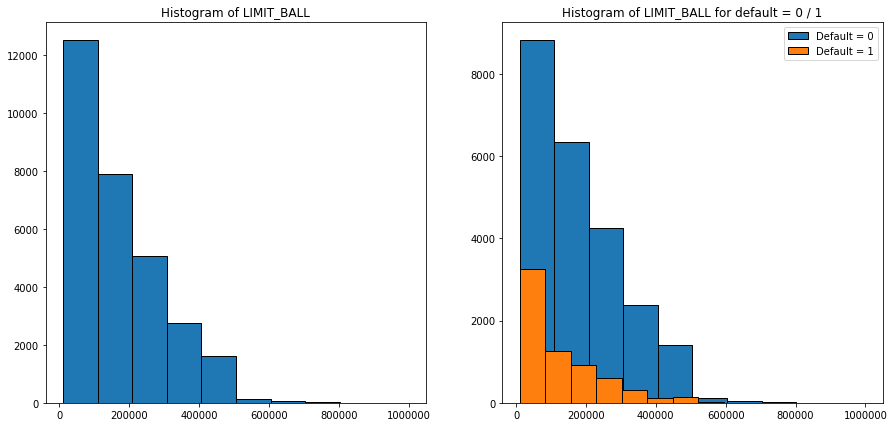

In [89]:
#histogram of LIMIT_BAL distribution
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of LIMIT_BALL')
_ = plt.hist(data['LIMIT_BAL'], edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of LIMIT_BALL for default = 0 / 1')
_ = plt.hist(data.LIMIT_BAL.loc[data.default == 0], edgecolor='k', label='Default = 0')
_ = plt.hist(data.LIMIT_BAL.loc[data.default == 1], edgecolor='k', label='Default = 1')
_ = plt.legend()

In [3]:
limit_bal_0 = data.loc[data.default == 0].LIMIT_BAL.values
limit_bal_1 = data.loc[data.default == 1].LIMIT_BAL.values

In [4]:
print(f"Median LIMIT_BAL for default = 0: {np.median(limit_bal_0)}")
print(f"Median LIMIT_BAL for default = 1: {np.median(limit_bal_1)}")

Median LIMIT_BAL for default = 0: 150000.0
Median LIMIT_BAL for default = 1: 90000.0


#### Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.
H0: медианные значения равны

H1: медианные значения отличаются

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [6]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
np.random.seed(0)

limit_bal_0_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_0, 1000)))
limit_bal_1_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_1, 1000)))

print("95% conf. int. median for LIMIT_BAL with default = 0:",  stat_intervals(limit_bal_0_median_scores, 0.05))
print("95% conf. int. median for LIMIT_BAL with default = 1:",  stat_intervals(limit_bal_1_median_scores, 0.05))

95% conf. int. median for LIMIT_BAL with default = 0: [150000. 150000.]
95% conf. int. median for LIMIT_BAL with default = 1: [80000. 90000.]


Как видно из интервальной оценки, медианы не совпадают. Заёмщики, которые не возвращают кредит, обычно берут меньшую сумму.

#### Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

H0: распределения выборок полностью равны

H1: распределения выборок отличаются на величину сдвига

In [8]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [9]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [10]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [11]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [12]:
print("p-value: %f" % permutation_test(limit_bal_0, limit_bal_1, max_permutations = 1000))

p-value: 0.001000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.

Результат является практически значимым, потому что разница в значениях медианы LIMIT_BAL значимо большая.

#### 2. Пол (SEX): 

In [32]:
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

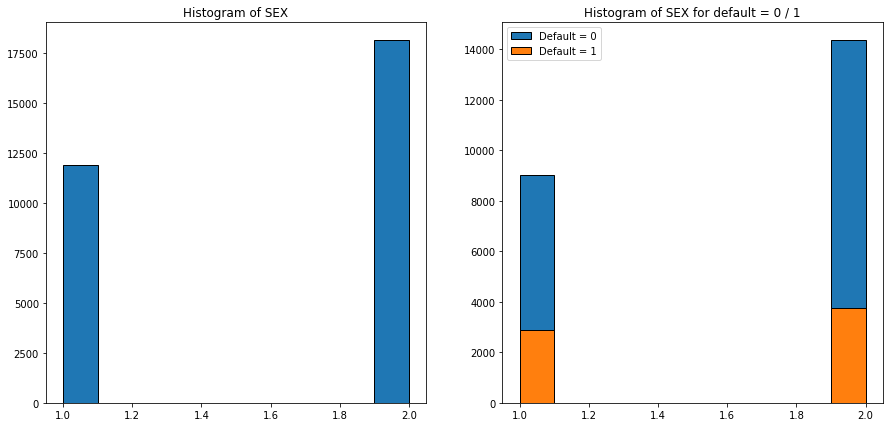

In [91]:
#histogram of SEX distribution
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of SEX')
_ = plt.hist(data['SEX'], edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of SEX for default = 0 / 1')
_ = plt.hist(data.SEX.loc[data.default == 0], edgecolor='k', label='Default = 0')
_ = plt.hist(data.SEX.loc[data.default == 1], edgecolor='k', label='Default = 1')
_ = plt.legend()

In [92]:
sex_0 = data.loc[data.default == 0].SEX.values
sex_1 = data.loc[data.default == 1].SEX.values

#### с помощью доверительного интервала

In [40]:
conf_int_0_lower, conf_int_0_upper = proportion_confint(np.where(sex_0 == 1)[0].shape[0], sex_0.shape[0])
conf_int_1_lower, conf_int_1_upper = proportion_confint(np.where(sex_1 == 1)[0].shape[0], sex_1.shape[0])

print(f"Conf. int. for prop. of men in default = 0: ({conf_int_0_lower:.4f}, {conf_int_0_upper:.4f})")
print(f"Conf. int. for prop. of men in default = 1: ({conf_int_1_lower:.4f}, {conf_int_1_upper:.4f})")

Conf. int. for prop. of men in default = 0: (0.3796, 0.3921)
Conf. int. for prop. of men in default = 1: (0.4210, 0.4449)


Как видно из интервальных оценок, сами интервалы не пересекаются, следовательно гендерный состав различается.

Построим доверительный интервал для разности двух долей независимых выборок.

In [93]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [94]:
print("Confidence interval: [%f, %f]" % proportions_confint_diff_ind(np.abs(sex_0 - 2), np.abs(sex_1 - 2)))

Confidence interval: [-0.060548, -0.033635]


#### Используем статистический Z-критерий для доли для двух независимых выборок.
H0: гендерный состав не отличается

H1: гендерный состав отличается

In [95]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [96]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [97]:
print(f"p-value: {proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_0 - 2), np.abs(sex_1 - 2)))}")

p-value: 4.472866521609831e-12


Гипотеза о равенстве гендерного распределния отвергается.

#### 3. Образование (EDUCATION): 

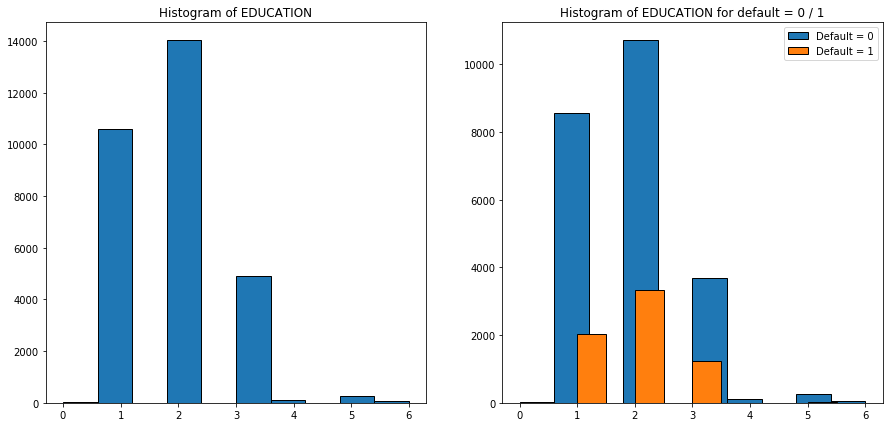

In [98]:
#histogram of EDUCATION distribution
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of EDUCATION')
_ = plt.hist(data['EDUCATION'], edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of EDUCATION for default = 0 / 1')
_ = plt.hist(data.EDUCATION.loc[data.default == 0], edgecolor='k', label='Default = 0')
_ = plt.hist(data.EDUCATION.loc[data.default == 1], edgecolor='k', label='Default = 1')
_ = plt.legend()

In [99]:
edu = data.EDUCATION

edu_0 = data.EDUCATION.loc[data.default == 0]
edu_1 = data.EDUCATION.loc[data.default == 1]

#### Произведём строгую проверку на соответствие данного распределения равномерному с помощью критерия согласия Пирсона хи-квадрат.
H0: рассматривая величина имеет равномерное распределение

H1: H0 не верна

In [103]:
#sample sizes for different education levels

edu_num_0 = np.array([edu_0[edu_0 == ed_val].shape[0] for ed_val in range(7)])
edu_num_1 = np.array([edu_1[edu_1 == ed_val].shape[0] for ed_val in range(7)])
edu_num = edu_num_0 + edu_num_1

for i in range(7):
    print(f'Edu lvl {i}: {edu_num_0[i]} / {edu_num_1[i]} | {edu_num[i]}')

Edu lvl 0: 14 / 0 | 14
Edu lvl 1: 8549 / 2036 | 10585
Edu lvl 2: 10700 / 3330 | 14030
Edu lvl 3: 3680 / 1237 | 4917
Edu lvl 4: 116 / 7 | 123
Edu lvl 5: 262 / 18 | 280
Edu lvl 6: 43 / 8 | 51


In [104]:
#proportions of credit returns

edu_prop = np.empty((len(np.unique(edu_0)), 2))

for i, ed_val in enumerate(np.unique(edu)):
    edu_prop[i, 0] = ed_val
    edu_prop[i, 1] = edu_0[edu_0 == ed_val].shape[0] / (edu_0[edu_0 == ed_val].shape[0] + edu_1[edu_1 == ed_val].shape[0])

In [105]:
#expected frequencies

prop_mean = edu_prop[:,1].mean()
exp_freq = np.array([prop_mean * edu_num[i] for i in range(7)])

for i in range(7):
    print(f'Edu lvl {i}: {int(exp_freq[i])} / {edu_num_0[i]} | {int(edu_num_0[i] - exp_freq[i])}')

Edu lvl 0: 12 / 14 | 1
Edu lvl 1: 9134 / 8549 | -585
Edu lvl 2: 12107 / 10700 | -1407
Edu lvl 3: 4243 / 3680 | -563
Edu lvl 4: 106 / 116 | 9
Edu lvl 5: 241 / 262 | 20
Edu lvl 6: 44 / 43 | -1


In [67]:
#chi-square criterion

stats.chisquare(edu_num_0, exp_freq, ddof = 1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

Гипотеза о том, что величина имеет равномерное распределение отвергается с очень высокой долей вероятности.

Результат имеет практическую значимость для выдачи кредита, доли возврата значимо отличаются для разных уровней образования.

#### 4. Семейное положение (MARRIAGE):

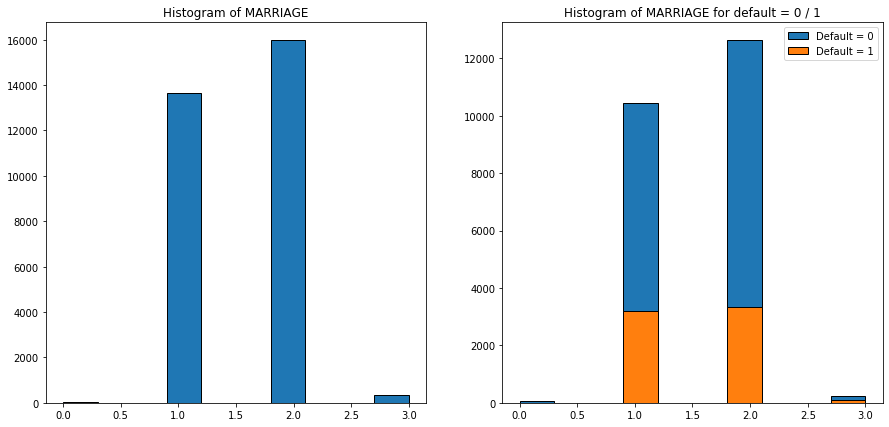

In [106]:
#histogram of MARRIAGE distribution
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of MARRIAGE')
_ = plt.hist(data['MARRIAGE'], edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of MARRIAGE for default = 0 / 1')
_ = plt.hist(data.MARRIAGE.loc[data.default == 0], edgecolor='k', label='Default = 0')
_ = plt.hist(data.MARRIAGE.loc[data.default == 1], edgecolor='k', label='Default = 1')
_ = plt.legend()

In [107]:
mar = data.MARRIAGE

mar_0 = data.loc[data.default == 0].MARRIAGE
mar_1 = data.loc[data.default == 1].MARRIAGE

mar.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [108]:
conf_mat = np.empty((len(mar.value_counts()), 2))

for i in range(len(mar.value_counts())):
    conf_mat[i, 0] = len(mar_0.loc[mar_0 == i])
    conf_mat[i, 1] = len(mar_1.loc[mar_1 == i])
    
conf_mat

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

Вычислим коэффициент V Крамера.

In [109]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [110]:
print(f'V Cramer stat value: {cramers_stat(conf_mat)}')

V Cramer stat value: 0.034478203662766466


Коэффициент Крамера принимает значение, близкое к нулю, когда взаимосвязь отсутствует.

Практическая значимость в данном результате также присутствует, т.к. исходя из этих данных нет разницы в том, с каким статусом MARRIAGE приходит человек за кредитом.

#### 5. Возраст (AGE)::

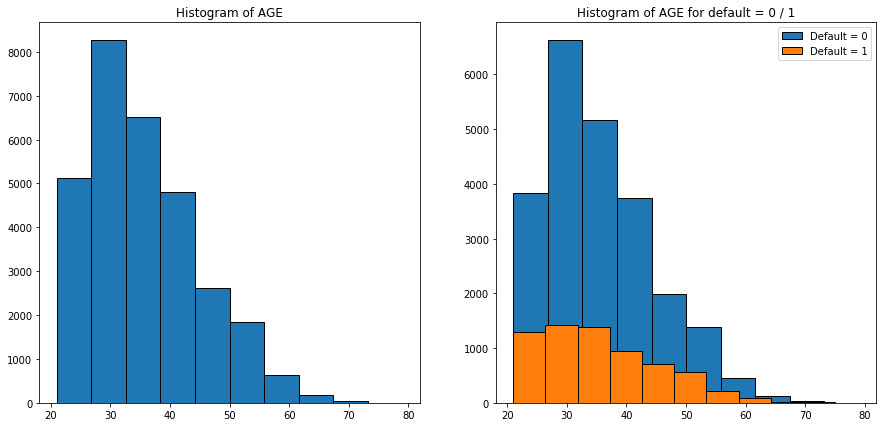

In [111]:
#histogram of AGE distribution
_ = plt.figure(1, figsize=(15,7))

_ = plt.subplot(121)
_ = plt.title('Histogram of AGE')
_ = plt.hist(data['AGE'], edgecolor='k')

_ = plt.subplot(122)
_ = plt.title('Histogram of AGE for default = 0 / 1')
_ = plt.hist(data.AGE.loc[data.default == 0], edgecolor='k', label='Default = 0')
_ = plt.hist(data.AGE.loc[data.default == 1], edgecolor='k', label='Default = 1')
_ = plt.legend()

In [112]:
age_0 = data.loc[data.default == 0].AGE.values
age_1 = data.loc[data.default == 1].AGE.values

In [113]:
print(f"Median AGE for default = 0: {np.median(age_0)}")
print(f"Median AGE for default = 1: {np.median(age_1)}")

Median AGE for default = 0: 34.0
Median AGE for default = 1: 34.0


#### Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.
H0: медианные значения равны

H1: медианные значения отличаются

In [114]:
np.random.seed(0)

age_0_median_scores = list(map(np.median, get_bootstrap_samples(age_0, 1000)))
age_1_median_scores = list(map(np.median, get_bootstrap_samples(age_1, 1000)))

print("95% conf. int. median for LIMIT_BAL with default = 0:",  stat_intervals(age_0_median_scores, 0.05))
print("95% conf. int. median for LIMIT_BAL with default = 1:",  stat_intervals(age_1_median_scores, 0.05))

95% conf. int. median for LIMIT_BAL with default = 0: [34. 34.]
95% conf. int. median for LIMIT_BAL with default = 1: [34. 35.]


Как видно из интервальной оценки, интервальные оценки для медианы пересекаются.

In [116]:
print("Difference between medians:", np.median(age_0) - np.median(age_1))

Difference between medians: 0.0


In [117]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_0_median_scores, age_1_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [0. 1.]


#### Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

H0: распределения выборок полностью равны

H1: распределения выборок отличаются на величину сдвига

In [85]:
print("p-value: %f" % permutation_test(age_0, age_1, max_permutations = 1000))

p-value: 0.014000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.

Результат является практически значимым, потому что разница в распределениях видна невооружённым взглядом и эти данные могут учитываться при выдаче кредита.